In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install gpytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 6.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manyl

In [ ]:
import torch
import tqdm
import numpy as np
import pandas as pd
import gpytorch
from torch.nn import Linear
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from gpytorch.means import ConstantMean, LinearMean
from gpytorch.kernels import ScaleKernel, RBFKernel, LinearKernel, MaternKernel, AdditiveKernel
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution
from gpytorch.distributions import MultivariateNormal
from gpytorch.models.deep_gps import DeepGPLayer, DeepGP
from gpytorch.mlls import DeepApproximateMLL, VariationalELBO
from gpytorch.likelihoods import MultitaskGaussianLikelihood
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cuda


In [ ]:
#Path to Feature CSV
features_csv = "/content/drive/MyDrive/Data/EEWS/EEW_features_2024-04-12.csv"
feature_list = [' pkev12 ', ' pkev23 ', ' durP ', ' tauPd ', ' tauPt ',
       ' PDd ', ' PVd ', ' PAd ', ' PDt ', ' PVt ', ' PAt ', ' ddt_PDd ',
               ' ddt_PVd ', ' ddt_PAd ']
label_list = [' PGA ', ' PGV ', ' tPGA ', ' tPGV ']
features_df = pd.read_csv(features_csv)

epsilon = 1e-7
feature_data = np.log10(np.where(np.isnan(features_df[feature_list].values) | (features_df[feature_list].values < 0), 0, features_df[feature_list].values) + epsilon)
label_data = np.log10(np.nan_to_num(features_df[label_list].values, nan=0.0) + epsilon)

In [ ]:
def calculate_accuracy(predicted_means, predicted_vars, test_y, alpha):
    num_tasks = predicted_means.shape[1]
    accuracies = []

    for i in range(num_tasks):
        means = predicted_means[:, i]
        vars = predicted_vars[:, i]
        test_values = test_y[:, i]

        std_devs = np.sqrt(vars)
        lower_bounds = means - alpha*std_devs
        upper_bounds = means + alpha*std_devs

        correct_predictions = (test_values >= lower_bounds) & (test_values <= upper_bounds)
        accuracy = np.mean(correct_predictions)
        accuracies.append(accuracy)

    return accuracies

#Construct a layer: initialize + forward
class DGPHiddenLayer(DeepGPLayer):
    def __init__(self, input_dims, output_dims, num_inducing=256, linear_mean=True):
        #Inducing points are points in input space that act as a representative summary for the entire dataset.
        #They make GP models scalable to larger datasets (optimized during training)
        inducing_points = torch.randn(output_dims, num_inducing, input_dims)
        batch_shape = torch.Size([output_dims])
        #Choose CVD since exact inference can be computationally prohibitive
        #Approximates the true posterior distribution with a multivariate normal distribution
        variational_distribution = CholeskyVariationalDistribution(
            num_inducing_points=num_inducing,
            batch_shape=batch_shape
        )
        #Defines how to propagate approximations through the model
        variational_strategy = VariationalStrategy(
            self,
            inducing_points,
            variational_distribution,
            learn_inducing_locations=True
        )

        super().__init__(variational_strategy, input_dims, output_dims)
        self.mean_module = ConstantMean() if linear_mean else LinearMean(input_dims)

        rbf_kernel = RBFKernel(ard_num_dims=input_dims, batch_shape=batch_shape)
        linear_kernel = LinearKernel(ard_num_dims=input_dims, batch_shape=batch_shape)
        matern_kernel = MaternKernel(nu=2.5, batch_shape=batch_shape, ard_num_dims=input_dims)
        additive_kernel = AdditiveKernel(rbf_kernel, matern_kernel)
        self.covar_module = ScaleKernel(matern_kernel, batch_shape=batch_shape, ard_num_dims = None)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

In [ ]:
#Construct a model: initiliaze + build architecture and forward
class MultitaskDeepGP(DeepGP):
    def __init__(self, train_x_shape,output_dims):
        #Initialize some stuff
        super().__init__()
        self.layers = torch.nn.ModuleList()
        self.num_layers = len(output_dims)
        #Given output_dims, which specifies the architecture of the network, we create it
        for i in range(len(output_dims)):
            if(i == 0):
                #first layer
                layer = DGPHiddenLayer(input_dims=train_x_shape[-1],output_dims=output_dims[i],linear_mean=True)
                self.layers.append(layer)
            else:
                #hidden layers
                layer = DGPHiddenLayer(input_dims=output_dims[i-1],output_dims=output_dims[i],linear_mean=True)
                self.layers.append(layer)
        #last layer
        self.last_layer = DGPHiddenLayer(input_dims=output_dims[-1],output_dims=num_tasks,linear_mean=False)
        self.likelihood = MultitaskGaussianLikelihood(num_tasks=num_tasks)


    def forward(self, inputs):
        #just propagating data through the network. go look at DGPHiddenLayer's forward function for unneceasry details
        rep = inputs
        for i, layer in enumerate(self.layers):
            rep = layer(rep)
        output = self.last_layer(rep)
        return output


    def predict(model, test_x):
        batch_size = 100
        n = test_x.size(0)
        means_list = []
        variances_list = []

        with torch.no_grad():
            for i in range(0, n, batch_size):
                batch_x = test_x[i:i + batch_size]
                preds = model.likelihood(model(batch_x)).to_data_independent_dist()
                means_list.append(preds.mean.mean(0))
                variances_list.append(preds.variance.mean(0))

        means = torch.cat(means_list)
        variances = torch.cat(variances_list)

        return means, variances

In [ ]:
X = feature_data
Y = label_data

train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.224, shuffle= False)#True, random_state=42)

In [ ]:
train_x = torch.tensor(train_x, dtype=torch.float32).to(device)
train_y = torch.tensor(train_y, dtype=torch.float32).to(device)

In [ ]:
num_tasks = train_y.shape[-1]
#OUTPUTDIM IS VERY IMPORTANT -> YOU DECIDE THE ARCHITECTURE OF THE MODEL HERE
#if: output_dim = [n_0,n_1,....,n_i]
#then: k belongs to the interval [1,i], a subset of N
#n_k means that the kth layer has n_k outputs (similarly, it takes in n_(k-1) inputs)
#the last layer is not defined with output_dims, since the number of its outputs depends on the problem
output_dims = [2]
model = MultitaskDeepGP(train_x.shape,output_dims).to(device)
model.train()
#Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
#ELBO measures how close variational distribution is to true posterior, so training a model with variational inference => maximize ELBO
mll = DeepApproximateMLL(VariationalELBO(model.likelihood, model, num_data=train_y.shape[0]))

#Matern: 0.0401 -> LEVELS OUT AROUND 600
#linear kerne：0.25 -> levels around 300
num_epochs = 500
epochs_iter = tqdm.tqdm(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    #reset gradients
    optimizer.zero_grad()
    #get output and all the other regular ml stuff
    output = model(train_x)
    loss = -mll(output, train_y)
    if loss.item()<=0:
      break
    epochs_iter.set_postfix(loss=loss.item())
    #backprop
    loss.backward()
    #update
    optimizer.step()

Epoch:  16%|█▌        | 80/500 [00:32<02:48,  2.49it/s, loss=0.000855]


In [ ]:
torch.cuda.empty_cache()

In [ ]:
model.eval()
model.likelihood.eval()
test_x = torch.tensor(test_x, dtype=torch.float32).to(device)
test_y = torch.tensor(test_y, dtype=torch.float32).cpu().numpy()
#redict on the test data
predicted_means, predicted_vars = model.predict(test_x)
predicted_means = predicted_means.cpu().numpy()
predicted_vars = predicted_vars.cpu().numpy()


#Multitask outputs -> compute metrics for each output separately
alpha = 1.5
mse_list = []
r2_list = []
for i in range(num_tasks):
    mse = mean_squared_error(test_y[:, i], predicted_means[:, i])
    r2 = r2_score(test_y[:, i], predicted_means[:, i])
    mse_list.append(mse)
    r2_list.append(r2)
accuracy_list = calculate_accuracy(predicted_means, predicted_vars, test_y, alpha)

print("MSE for each task:", mse_list)
print("R2 for each task:", r2_list)
print("Accuracy for each task", accuracy_list)

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/interpolation.py:71: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:78.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:621.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


MSE for each task: [0.17898872, 0.16125186, 0.040235426, 0.024408532]
R2 for each task: [0.6458339465737059, 0.4839907828872051, 0.3475238756980945, 0.4982893572811822]
Accuracy for each task [0.7281355932203389, 0.7816949152542373, 0.9254237288135593, 0.9322033898305084]


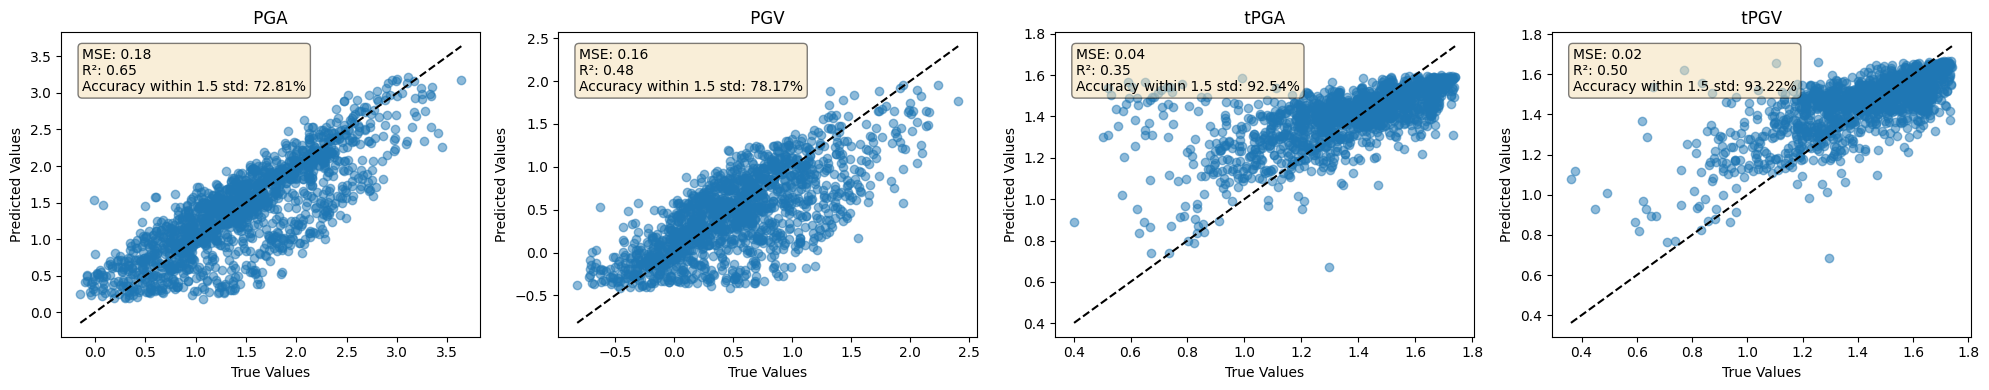

In [ ]:
# Plotting
label_no = test_y.shape[-1]
fig, axes = plt.subplots(nrows=1, ncols=label_no, figsize=(5 * label_no, 4))

for i in range(label_no):
    ax = axes[i] if label_no > 1 else axes
    ax.scatter(test_y[:, i], predicted_means[:, i], alpha=0.5)  # Scatter plot
    ax.set_title(f'{label_list[i]}')
    ax.set_xlabel('True Values')
    ax.set_ylabel('Predicted Values')
    ax.plot([test_y[:, i].min(), test_y[:, i].max()], [test_y[:, i].min(), test_y[:, i].max()], 'k--')  # Diagonal line
    textstr = f'MSE: {mse_list[i]:.2f}\nR²: {r2_list[i]:.2f}\nAccuracy within {alpha} std: {accuracy_list[i]:.2%}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()